### 数据准备
我们准备好了mnist的数据集`mnist.pkl.gz`，以及相应的载入数据的代码，用法如下：

In [1]:
import pickle
import gzip
import numpy as np


class MnistData:
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    test_x = []
    test_y = []

    def __init__(self, filename='mnist.pkl.gz'):
        f = gzip.open(filename, 'rb')
        f.seek(0)
        train, val, test = pickle.load(f, encoding='bytes')
        f.close()

        self.train_x = train[0]
        self.train_y = np.reshape(train[1], (-1, 1))
        self.val_x = val[0]
        self.val_y = np.reshape(val[1], (-1, 1))
        self.test_x = test[0]
        self.test_y = np.reshape(test[1], (-1, 1))

    def get_training_set(self, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
        ind = np.isin(self.train_y, labels).flatten()
        print('{} pairs in the training set.'.format(np.sum(ind)))
        return (self.train_x[ind, :], self.train_y[ind])

    def get_validation_set(self, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
        ind = np.isin(self.val_y, labels).flatten()
        print('{} pairs in the validatioin set.'.format(np.sum(ind)))
        return (self.val_x[ind, :], self.val_y[ind])

    def get_test_set(self, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
        ind = np.isin(self.test_y, labels).flatten()
        print('{} pairs in the test set.'.format(np.sum(ind)))
        return (self.test_x[ind, :], self.test_y[ind])

测试使用上述Class，获取mnist数据：

In [2]:
data = MnistData()
X, y = data.get_training_set([0, 1])

10610 pairs in the training set.


上面的代码中，我们指定只载入mnist中数字0和1的训练数据。

接下来，我们可以检查一下载入的数据维度：

In [3]:
print(X.shape, y.shape)

(10610, 784) (10610, 1)


这表明，我们的特征数据`X`是10610行，每行特征维度是`784`维，与之对应，类别`y`也是10610行，每行对应是类别信息:${0,1}$。

我们可以尝试可视化`X`中的一些图片，需要先将`784`维的向量转换成`28x28`的特征图：

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline 

plt.subplot(1, 4, 1)
plt.imshow(np.reshape(X[0, :], (28, 28)))
plt.subplot(1, 4, 2)
plt.imshow(np.reshape(X[1, :], (28, 28)))
plt.subplot(1, 4, 3)
plt.imshow(np.reshape(X[2, :], (28, 28)))
plt.subplot(1, 4, 4)
plt.imshow(np.reshape(X[3, :], (28, 28)))

看，我们成功的可视化出了一些手写体数字`0`和一张手写体数字`1`！同时，可以看出数据集的前三张图中，有3个`1`和1个`0`。

我们也可以尝试检查一下`0`和`1`在整个训练数据集中的分布情况：

(array([4932., 5678.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

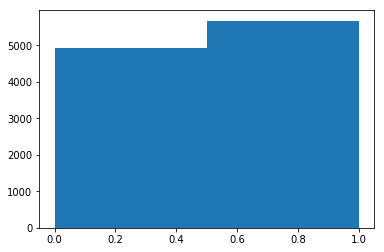

In [5]:
plt.hist(y, 2)

可以看出来，`1`的数量比`0`多一些。通常情况下，我们希望我们的数据集中，各个不同类的数据量是均衡的，但这不总能被满足。

### sigmoid函数
在逻辑回归中，我们使用$sigmoid$函数将任意实数映射到可以表示概率$[0,1]$的区间内。

sigmoid函数为: $$s(z) = \frac{e^z}{1+e^z}=\frac{1}{1+e^{-z}} $$

python实现起来非常简单：

In [6]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

让我们看一下sigmoid函数是什么样的：

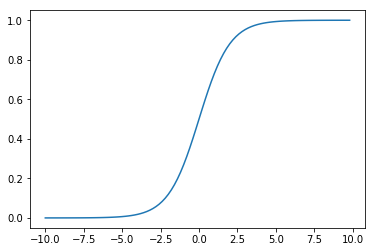

In [7]:
x = np.arange(-10., 10., 0.2)
y = sigmoid(x)
plt.plot(x, y)

可以看到$sigmoid$函数是一个s形的单调递增曲线，将输入映射到$[0,1]$区间内。

完整的逻辑回归数学模型则为：
$$g(x)=s(w^Tx+b)$$
对于多个数据构成的批量数据的向量化的形式则为：
$$g(X)=s(Xw+b)$$

注意这里的$X$中的数据向量为行向量，每行代表一个数据。

我们可以借助numpy库实现这个矩阵乘法，并命名该函数为`predict`：

In [ ]:
def preidct(X, w, b):
    return sigmoid(np.dot(X, w) + b)

### 损失函数
我们使用交叉熵作为逻辑回归的损失函数，又称为log损失函数：
$$L=-\frac{1}{n}\sum_{i=1}^{n} \left[ y^ilog(g(x^i))+(1-y^i)log(1-g(x^i))\right]$$

向量化表示的公式：
$$L=\frac{1}{n}(-y^Tlog(g(X))-(1-y)^Tlog(1-g(X)))$$

下面给出了此损失函数的python实现(numpy中，与dot函数不同，'* '号表示element-wise的乘法）：

In [ ]:
pred = predict(X, w, b)
loss = np.mean(-y*np.log(pred) - (1-y)*np.log(1-pred))

需要注意的是上面的损失函数中，没有正则项。带有正则项的损失函数为
$$L=\frac{1}{n}\left(-y^Tlog(g(X))-(1-y)^Tlog(1-g(X))+\lambda||w||^2 \right)$$
其中$\lambda$是控制正则约束的权重，也称为权重衰减（weight decay）系数。

**请自行实现此带有正则项的损失函数。**

### 梯度下降法
为了优化上述损失函数，我们可以使用梯度下降法，需要对损失函数求导。$sigmoid$函数的一项很好的特性是，我们可以非常方便的对其求导：
$$s'(z)=s(z)(1-s(z))$$
这个性质也会使损失函数的导数计算非常简单(推导过程见课件slides)：
$$L'=\frac{1}{n}X^T(g(X)-y)$$
其中$L'$表示损失函数相对于$w$的偏导。

In [ ]:
diff = preidct(X, w, b) - y
grad_w = np.dot(X.T, diff)/y.size

**这里只给了$w$的梯度，那么$b$的梯度如何计算？**

如果用`lr`表示梯度下降中的学习率（learning rate），那么梯度下降的权值更新便非常直接了：

In [ ]:
w -= lr*grad_w
b -= lr*grad_b

### 逻辑回归
有了这些之后，我们可以尝试构建一个LogisticRegression的类，来完成我们需要的功能。

In [15]:
class LogisticRegressioin:
    def __init__(self, d, weight_decay=0, lr=0.01, max_iter=100):
        self.w = np.zeros((d, 1))
        self.b = 0
        self.weight_decay = weight_decay
        self.lr = lr
        self.max_iter = max_iter
        self.losses = []

    def predict(self, X):
        return sigmoid(np.dot(X, self.w) + self.b)

    def gradient(self, X, y):
        pred = self.predict(X)
        diff = pred - y
        self.grad_w = np.dot(X.T, diff)/y.size
        self.grad_b = 0

    def reg_loss(self, X, y):
        pred = self.predict(X)
        # loss = np.mean(-y*np.log(pred) - (1-y)*np.log(1-pred))
        loss = -np.sum(np.log(pred[y == 1])) - np.sum(np.log(1 - pred[y == 0]))
        loss /= y.size
        return loss

    def accuracy(self, X, y):
        pred = np.round(self.predict(X))
        return np.mean(pred == y)

    def fit(self, X, y, method='BGD', verbose=True):
        assert method in ['SGD', 'BGD']
        if method == 'SGD':
            return self._sgd(X, y, verbose)
        elif method == 'BGD':
            return self._bgd(X, y, verbose)

    def _bgd(self, X, y, verbose):
        for i in range(self.max_iter):
            self.gradient(X, y)
            self.w -= self.lr*self.grad_w
            self.b -= self.lr*self.grad_b
            loss = self.reg_loss(X, y)
            if verbose:
                print("iteration:{0:3d}, loss={1:05f}".format(i, loss))
            self.losses.append(loss)

    def _sgd(self, X, y, verbose):
        raise NotImplementedError

### Putting it all together
在mnist中的0和1数据上做完整的逻辑回归训练，整个过程包含了训练、验证和测试。使用不同的超参数在训练集上训练模型，并利用验证集的精度将最好的训练模型记录下来，最终在测试集上测试记录的最好的模型。

10610 pairs in the training set.
2055 pairs in the validatioin set.
2115 pairs in the test set.
validation accuracy = 99.85%


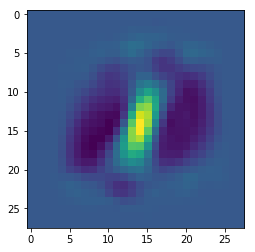

validation accuracy = 99.85%


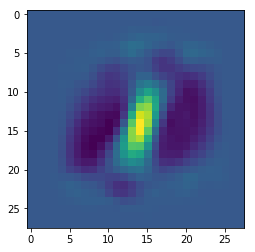

test accuracy = 99.95%


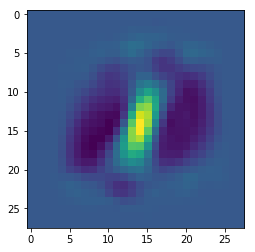

In [16]:
import copy


data = MnistData()
X, y = data.get_training_set([0, 1])
X_val, y_val = data.get_validation_set([0, 1])
X_test, y_test = data.get_test_set([0, 1])

best_acc = 0
for lr in [1, 0.1]:
    reg = LogisticRegressioin(X.shape[1], lr)
    reg.fit(X, y, method='BGD', verbose=False)
    acc = reg.accuracy(X, y)
    acc_val = reg.accuracy(X_val, y_val)
    print("validation accuracy = {0:2.2%}".format(acc_val))
    plt.imshow(np.reshape(reg.w, (28, 28)))
    plt.show()
    if acc_val > best_acc:
        best_acc = acc_val
        best_reg = copy.deepcopy(reg)

print("====================================")
acc_test = best_reg.accuracy(X_test, y_test)
print("test accuracy = {0:2.2%}".format(acc_test))

plt.plot(best_reg.losses)
plt.show()
plt.imshow(np.reshape(best_reg.w, (28, 28)))
plt.show()

### More to play with

1. 补充梯度计算中关于`b`的偏导数（`self.grad_b`）
2. 完成随机梯度下降法 （`_sgd`函数）
3. 实现带有$L_2$正则项的岭回归
4. 测试更多的不同的超参数（`weight_decay`，`lr`，`max_iter`）
5. 比较BGD和SGD的收敛速度